## Haplotype validation

Haplotype validation based on parent/progeny and synthetic X as a gold standard.

Recent updates:


- Read in raw phased data and draw bar plots from those.



to do

- use combined zip zarr instead of individual zarr
- use reperformed phasing analysis to validate


In [1]:
%run setup.ipynb 

In [2]:
rcParams['text.usetex'] = False

In [3]:
from pathlib import Path
from matplotlib.ticker import FuncFormatter

In [4]:
def fposition(x, pos):
    'The two args are the value and tick position'
    return '%2d' % (x*1e-6)

In [5]:
autosomes = "2R", "2L", "3R", "3L"

In [6]:
meta_fn = Path(phase2_ar1.samples_dir) / "cross.samples.meta.txt"
meta_info = pandas.read_csv(meta_fn, sep="\t", index_col=0).set_index("ox_code")
meta_info.head()

,cross,role,n_reads,median_cov,mean_cov,sex,colony_id
ox_code,,,,,,,
AD0142-C,18-5,parent,60486753,26,25.824447,F,Ghana
AD0143-C,18-5,parent,58509103,19,18.800118,M,Kisumu/G3
AD0146-C,18-5,progeny,101612499,44,43.494594,NaN,NaN
AD0147-C,18-5,progeny,50710020,16,16.284487,NaN,NaN
AD0148-C,18-5,progeny,59023991,19,18.978021,NaN,NaN


In [7]:
meta_info.groupby(["cross", "role"]).size()

cross  role   
18-5   parent      2
       progeny    20
29-2   parent      2
       progeny    20
36-9   parent      2
       progeny    20
37-3   parent      2
       progeny    20
42-4   parent      2
       progeny    14
45-1   parent      2
       progeny    20
46-9   parent      2
       progeny    20
47-6   parent      2
       progeny    20
73-2   parent      2
       progeny    19
78-2   parent      2
       progeny    19
80-2   parent      2
       progeny    20
dtype: int64

In [8]:
xgp = meta_info.groupby("cross")

In [9]:
def plot_transmission(painting, ax=None, title=None, palette_name='colorblind'):

    palette = sns.color_palette(palette_name)

    # set figure height depending on number of haplotypes

    # map painting codes onto colours
    cmap = mpl.colors.ListedColormap([
        'white',      # 0 = undetermined
        palette[0],  # 1 = allele inherited from first parental haplotype
        palette[2],  # 2 = allele inherited from second parental haplotype
        'lightgrey',     # 3 = reference allele, also carried by both parental haplotypes
        'lightgrey',     # 4 = non-reference allele, also carried by both parental haplotypes
        'black',     # 5 = non-parental allele (i.e., Mendelian error)
        palette[5],  # 6 = either or both parental alleles missing
        'white',     # 7 = missing allele
    ])

    # plot painting
    ax.pcolormesh(painting.T, cmap=cmap, vmin=0, vmax=7)

    # tidy up axes
    ax.set_yticks(np.arange(painting.shape[1]) + .5)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    if title:
        ax.set_title(title)

In [10]:
genome = phase2_ar1.genome_agamp3

In [11]:
transmission_d = Path(
    "/kwiat/2/coluzzi/ag1000g/data/analysis",
    "20190514-tmp-dev-phasing")

In [12]:
zfn = transmission_d / "ag1000g.crosses.phase2.ar1.haplotypes.zip"

In [13]:
zz = zarr.ZipStore(zfn)
zh = zarr.Group(zz)

In [14]:
zh["2L"].tree()

2L
 ├── calldata
 │   └── genotype (1190953, 234, 2) int8
 ├── samples (234,) <U8
 └── variants
     ├── ALT (1190953,) |S20
     ├── POS (1190953,) int32
     └── REF (1190953,) |S20

In [15]:
def get_phased_genotypes(mother, father, progeny, fhcallset):
    
    samples = list(fhcallset["samples"].astype("<U8"))
    
    assert len(mother) == len(father) == 1, \
        "one mother and father must be specified"
    
    # first get progeny:
    proix = sorted([samples.index(s) for s in progeny])
    
    matix = [samples.index(s) for s in mother]
    patix = [samples.index(s) for s in father]
    
    gn = allel.GenotypeChunkedArray(fhcallset["calldata/genotype"])
    g_prime = allel.GenotypeChunkedArray(
        zarr.zeros((gn.shape[0], 2, 2), dtype="int8"))
    
    progeny_g = gn.take(proix, axis=1)
    g_prime[:, 0] = np.squeeze(gn.take(matix, axis=1))
    g_prime[:, 1] = np.squeeze(gn.take(patix, axis=1))
    g_prime.append(progeny_g, axis=1)
    
    return g_prime, allel.SortedIndex(fhcallset["variants/POS"])

In [16]:
from matplotlib.pyplot import GridSpec

In [17]:
gs = GridSpec(
    4, len(autosomes), 
    height_ratios=[5, 1, 5, 1],
    width_ratios=[len(genome[k]) for k in autosomes],
    wspace=0.1, hspace=0.1)

In [18]:
skipifdone = True

In [19]:
def make_transmission_plot(cross_id, df_meta):
    
    fig = plt.figure(figsize=(8, 4))

    plotfn =  Path("../artwork", "haplotype-validation",
                   "allele_transmission_{cross_id}.png".format(cross_id=cross_id))
    
    if skipifdone and plotfn.is_file():
        return None
    
    mother = df_meta.query("role == 'parent'").query("sex == 'F'").index
    father = df_meta.query("role == 'parent'").query("sex == 'M'").index
    progeny = df_meta.query("role == 'progeny'").index
    
    for i, chrom in enumerate(autosomes):
            
        phased_genotypes, pos = get_phased_genotypes(
            mother, father, progeny, zh[chrom])
            
        het_loci = allel.GenotypeChunkedArray(
            phased_genotypes[:, :2]).is_het().max(axis=1) > 0
        
        phased_genotypes = phased_genotypes.compress(het_loci, axis=0)

        haplotypes_progeny = allel.GenotypeChunkedArray(phased_genotypes[:, 2:, :])
        pos = pos.compress(het_loci)

        for ix, parent_label in enumerate(["Maternal", "Paternal"]):
            ax = fig.add_subplot(gs[ix * 2, i])
        
            # pull out mother's genotypes from the first column
            genotypes_parent = phased_genotypes[:, ix]

            # convert to haplotype array
            haplotypes_parent = genotypes_parent.to_haplotypes()

            # pull out maternal haplotypes from the progeny
            haplotypes_progeny_given_parent = haplotypes_progeny[:, :, ix]

            painting = allel.paint_transmission(
                haplotypes_parent, haplotypes_progeny_given_parent)
  
            # het_only
            hh = genotypes_parent.is_het().squeeze()
        
            painting = np.compress(hh, painting, axis=0)
            plot_pos = pos.compress(hh, axis=0)
            
            # skip every 2 rows.
            plot_transmission(painting, ax=ax)
            ax.tick_params(direction='out', length=1, width=1)

            if i == 0:
                ax.set_ylabel(parent_label)

            # make the locator plot...
            ax2 = fig.add_subplot(gs[ix * 2 + 1, i])
            allel.plot_variant_locator(plot_pos, ax=ax2, line_kwargs={"lw": 0.5})
            
            _ = ax2.set_xticks(np.arange(0, len(genome[chrom]), 1e7))
            _ = ax2.xaxis.set_ticks_position("bottom")
            _ = ax2.tick_params(length=2, width=2)
            if parent_label == "Paternal":
                
                formatter = FuncFormatter(fposition)
                ax2.xaxis.set_major_formatter(formatter)
                ax2.set_xlabel(chrom)
            else:
                ax2.set_xticklabels([])

    _ = fig.text(0.5, 0.03, 'Genomic position (Mbp)', ha='center', va='top')
    _ = fig.suptitle("Haplotype transmission for {cross_id}".format(cross_id=cross_id))

    fig.savefig(
        plotfn,
        dpi=150,
        bbox_inches='tight')

In [20]:
for xid, ff in xgp:
    print("processing", xid)
    make_transmission_plot(xid, ff)
    plt.close("all")

processing 18-5
processing 29-2
processing 36-9
processing 37-3
processing 42-4
processing 45-1
processing 46-9
processing 47-6
processing 73-2
processing 78-2
processing 80-2


## Panel B

In [21]:
from intervaltree import IntervalTree
import pyfasta

In [22]:
import re
def find_reference_gaps(genome_fa, gap_size=300):

    # fix on a gapsize of 1kb, as ld breaks down over this distance and
    # do chunks of 10k at a time. look for consecutive Ns.
    size = 10000
    gaps = list()
    
    match = "N{{{n}}}?".format(n=gap_size)
    
    for i in range(0, len(genome_fa), size - (2 * gap_size)):
        text = genome_fa[i:i+size]

        for m in re.finditer(match, text, flags=re.IGNORECASE):
            gaps.append((i + m.start(), i + m.end()))

    tree = IntervalTree.from_tuples(gaps)
    tree.merge_overlaps()

    return np.array([[iv.begin, iv.end] for iv in sorted(tree)])

In [23]:
# load data from data release

In [24]:
eval_path = transmission_d / "evaluation"

In [25]:
frame_d = {
    chrom: eval_path / "{chrom}/table_switch_errors.txt".format(chrom=chrom)
    for chrom in chromosomes}

In [26]:
for k, v in frame_d.items():
    print(k, v.absolute(), v.is_file())   

2R /kwiat/2/coluzzi/ag1000g/data/analysis/20190514-tmp-dev-phasing/evaluation/2R/table_switch_errors.txt True
2L /kwiat/2/coluzzi/ag1000g/data/analysis/20190514-tmp-dev-phasing/evaluation/2L/table_switch_errors.txt True
3R /kwiat/2/coluzzi/ag1000g/data/analysis/20190514-tmp-dev-phasing/evaluation/3R/table_switch_errors.txt True
3L /kwiat/2/coluzzi/ag1000g/data/analysis/20190514-tmp-dev-phasing/evaluation/3L/table_switch_errors.txt True
X /kwiat/2/coluzzi/ag1000g/data/analysis/20190514-tmp-dev-phasing/evaluation/X/table_switch_errors.txt True
Y_unplaced /kwiat/2/coluzzi/ag1000g/data/analysis/20190514-tmp-dev-phasing/evaluation/Y_unplaced/table_switch_errors.txt False
UNKN /kwiat/2/coluzzi/ag1000g/data/analysis/20190514-tmp-dev-phasing/evaluation/UNKN/table_switch_errors.txt False


In [27]:
def draw_msd_across_genome(genome_pos, marker_dist, mean_switch_dist, number_markers, chrom, ax):

    mean_switch_dist[number_markers < 50] = np.NaN
        
    ax.plot(genome_pos, 2 * marker_dist, 'k-', linewidth=1.0)
    ax.plot(genome_pos, mean_switch_dist, 'r-',  linewidth=1.0)

    ax.grid(True)
    
    ax.set_yscale("log")
    ax.set_ylim((100, 200000))
    ax.set_xlim((0, len(genome[chrom])))
    
    _ = ax.set_xticks(np.arange(0, len(genome[chrom]), 1e7))

    return ax

In [28]:
def draw_switch_err_rate(genome_pos, rate, number_markers, chrom, ax):

    rate[number_markers < 50] = np.NaN   
    ax.plot(genome_pos, 1 - rate, 'r-', linewidth=1.0)

    ax.grid(True)
    ax.set_ylim((0.82, 1.0))
    ax.set_xlim((0, len(genome[chrom])))
    
    _ = ax.set_xticks(np.arange(0, len(genome[chrom]), 1e7))
    formatter = FuncFormatter(fposition)
    ax.xaxis.set_major_formatter(formatter)

    return ax

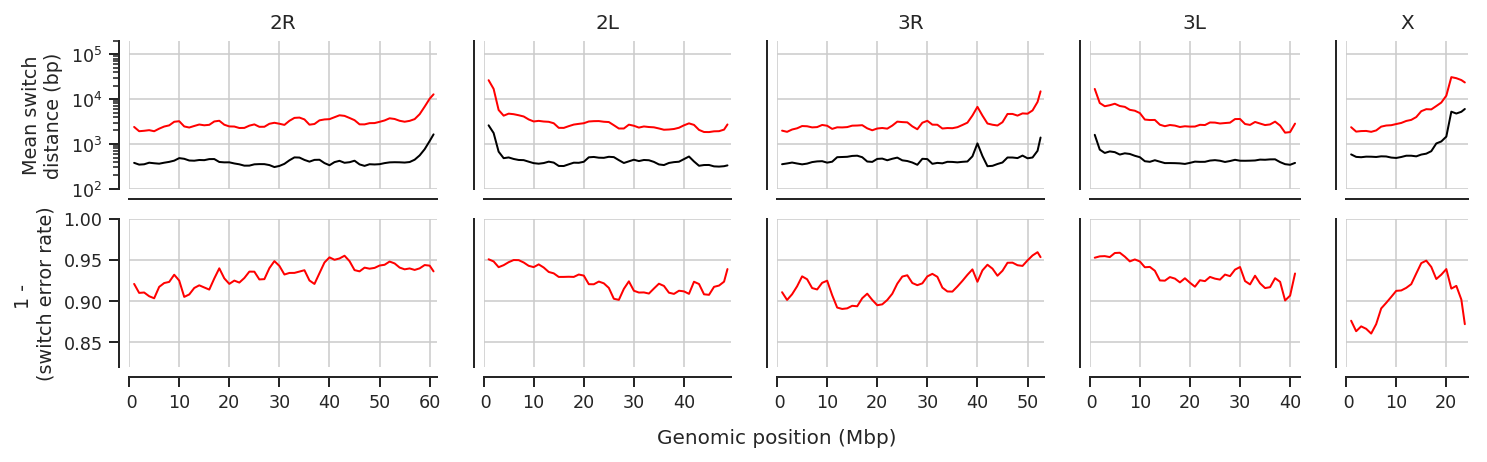

In [29]:
contigs = chromosomes[:5]
# contigs = "2R", "2L", "3R", "3L"

gs = GridSpec(
    2, len(contigs), 
    width_ratios=[len(genome[k]) for k in contigs], 
    wspace=0.2)

fig = plt.figure(figsize=(12, 3))

for i, chrom in enumerate(contigs):

    df = pandas.read_csv(frame_d[chrom], sep="\t")

    ax1 = fig.add_subplot(gs[0, i])
    ax2 = fig.add_subplot(gs[1, i])
    sns.despine(ax=ax1, offset=5)
    sns.despine(ax=ax2, offset=5)

    pos = 0.5 * np.array(df.start + df.stop)
    mean_marker_d = np.array(df.mean_marker_dist)
    mean_switch_d = np.array(df.mean_switch_dist)

    n_markers = np.array(df.n_markers)
    err_rate = np.array(df.err_rate)

    draw_msd_across_genome(pos, mean_marker_d, mean_switch_d, n_markers, chrom, ax1)
    draw_switch_err_rate(pos, err_rate, n_markers, chrom, ax2)

    if i == 0:
        ax1.set_ylabel("Mean switch\ndistance (bp)")
        ax2.set_ylabel("1 - \n(switch error rate)")
    else:
        ax1.yaxis.set_tick_params(which="both", width=0)
        ax2.yaxis.set_tick_params(which="both", width=0)

        ax1.set_yticklabels([])
        ax2.set_yticklabels([])

    ax1.xaxis.set_tick_params(which="both", width=0)
    ax1.set_xticklabels([])
    ax1.set_title(chrom, fontsize=10)

fig.text(0.5, -0.04, 'Genomic position (Mbp)', ha='center', va='center', fontsize=10)

fig.savefig("../artwork/haplotype-validation/switch_across_genome.png", 
            dpi=300, bbox_inches='tight')

## Finally compute the per chromosome means presented in the paper

In [30]:
qdf = pandas.concat({chrom: pandas.read_csv(
            frame_d[chrom], sep="\t") for chrom in autosomes})

qdf

start      stop  n_markers  n_errors  err_rate    distance  \
2L 0          1   2000000       9618       500  0.049417  12524846.0   
   1    1000001   3000000      19362      1063  0.052044  17004655.0   
   2    2000001   4000000      72104      4523  0.059026  24332964.0   
   3    3000001   5000000     130000      7796  0.056576  31447945.0   
   4    4000001   6000000     111437      6232  0.052962  27972800.0   
   5    5000001   7000000     132786      7040  0.050348  30827697.0   
   6    6000001   8000000     175926      9352  0.050476  38799204.0   
   7    7000001   9000000     144752      8154  0.053327  31660038.0   
   8    8000001  10000000     152509      9283  0.057376  30817405.0   
   9    9000001  11000000     196040     12282  0.058957  36716055.0   
   10  10000001  12000000     197005     11604  0.055626  35881636.0   
   11  11000001  13000000     196957     12447  0.059440  37075191.0   
   12  12000001  14000000     185671     12869  0.064818  37544019.0   
   13  13000001  15000000     184420     13140  0.066511  35544718.0   
   14  14000001  16000000     214239     16337  0.070853  34776307.0   
   15  15000001  17000000     204694     15603  0.070827  33102357.0   
   16  16000001  18000000     189758     14424  0.070643  33497138.0   
   17  17000001  19000000     173038     13192  0.070837  33193403.0   
   18  18000001  20000000     163532     11919  0.067933  31198147.0   
   19  19000001  21000000     149793     11145  0.069250  30086903.0   
   20  20000001  22000000     116009     10045  0.079688  29324370.0   
   21  21000001  23000000     120035     10407  0.079783  30895177.0   
   22  22000001  24000000     131185     10864  0.076481  32506620.0   
   23  23000001  25000000     131899     11255  0.078622  32451728.0   
   24  24000001  26000000     120048     11037  0.084197  31160506.0   
   25  25000001  27000000     120413     12992  0.097388  30713142.0   
   26  26000001  28000000     145609     15946  0.098703  31817740.0   
   27  27000001  29000000     158927     14827  0.085333  30023493.0   
   28  28000001  30000000     143606     11848  0.076215  29514215.0   
   29  29000001  31000000     137314     13189  0.087633  30662079.0   
...         ...       ...        ...       ...       ...         ...   
3R 23  23000001  25000000     125168     10742  0.079038  31142317.0   
   24  24000001  26000000     131001      9922  0.070407  28371691.0   
   25  25000001  27000000     115589      8545  0.068837  24146701.0   
   26  26000001  28000000     121918     10348  0.078236  23588958.0   
   27  27000001  29000000     146306     12873  0.080871  25205579.0   
   28  28000001  30000000     117910     10067  0.078663  27602025.0   
   29  29000001  31000000     113691      8585  0.070210  26232948.0   
   30  30000001  32000000     130378      9382  0.067129  23600881.0   
   31  31000001  33000000     101089      7694  0.070728  19190810.0   
   32  32000001  34000000     117784     10787  0.083899  21865737.0   
   33  33000001  35000000     139366     13530  0.088492  27954223.0   
   34  34000001  36000000     137278     13359  0.088683  27373220.0   
   35  35000001  37000000     133754     12022  0.082469  26098951.0   
   36  36000001  38000000     121181      9918  0.075653  24285722.0   
   37  37000001  39000000     115550      8471  0.068303  23566591.0   
   38  38000001  40000000      81356      5351  0.061714  21620982.0   
   39  39000001  41000000      46346      3852  0.076736  23902610.0   
   40  40000001  42000000     105600      7087  0.062891  28477065.0   
   41  41000001  43000000     195835     11631  0.056062  31393224.0   
   42  42000001  44000000     189065     12240  0.060803  30864078.0   
   43  43000001  45000000     153509     11451  0.069417  27530561.0   
   44  44000001  46000000     142430      9636  0.063367  27598915.0   
   45  45000001  47000000     108257      6141  0.053681  27102127.0   
   46  46000001  48000000     102237      5782  0.

In [31]:
summed = qdf.sum()

In [51]:
qdf.mean_switch_dist.describe()

count      204.000000
mean      3506.635204
std       2680.694477
min       1788.160250
25%       2419.027299
50%       2733.611703
75%       3398.709096
max      26351.921778
Name: mean_switch_dist, dtype: float64

In [32]:
# this is the autosomal mean switch distance
mean_switch_dist = (summed.distance/summed.n_markers)/(summed.n_errors/summed.n_markers)
mean_switch_dist

2667.3842675417277

In [45]:
no_overlaps = qdf[::2].sum(0)

In [48]:
# autosomal SER
1 - (no_overlaps.n_errors / no_overlaps.n_markers)

0.9217682477563017

In [33]:
rrate = 0.983

In [34]:
(mean_switch_dist/1e6) * rrate

0.002622038734993518

In [35]:
def haldane(r):
    return -np.log(1- (2 * r))/2

In [36]:
summed.n_errors/summed.n_markers

0.07829501456167058

In [37]:
haldane(summed.n_errors/summed.n_markers)

0.08515105775011017

In [49]:
xdf = pandas.read_csv(frame_d["X"], sep="\t")
xno_overlaps = xdf[::2].sum(0)

In [52]:
xdf.mean_switch_dist.describe()

count       24.000000
mean      7942.584472
std       9330.229967
min       1866.359952
25%       2418.439631
50%       3352.182406
75%       7346.369169
max      30827.687615
Name: mean_switch_dist, dtype: float64

In [53]:
xdf

,start,stop,n_markers,n_errors,err_rate,distance,mean_marker_dist,mean_switch_dist
0,1,2000000,277686,39321,0.124038,81442556.0,293.290105,2364.513014
1,1000001,3000000,314440,49829,0.136792,81225344.0,258.317466,1888.399226
2,2000001,4000000,310541,46767,0.130887,78834133.0,253.860627,1939.539268
3,3000001,5000000,302364,46726,0.133851,79056086.0,261.459982,1953.367828
4,4000001,6000000,312790,50765,0.139635,81515939.0,260.609159,1866.359952
5,5000001,7000000,315600,46385,0.128141,81124204.0,257.047541,2005.979394
6,6000001,8000000,302175,37002,0.109093,80317213.0,265.797015,2436.415171
7,7000001,9000000,305667,34848,0.102339,80682539.0,263.955674,2579.225962
8,8000001,10000000,323958,34068,0.095155,80816483.0,249.465928,2621.676888
9,9000001,11000000,331097,31853,0.087761,80903983.0,244.351302,2784.268515


In [50]:
# autosomal SER
1 - (xno_overlaps.n_errors / xno_overlaps.n_markers)

0.8903083315773217

In [39]:
xsum = xdf.sum(0)

In [40]:
pd.DataFrame(xsum).T.eval("(distance/n_markers)/(n_errors/n_markers)")

0    2811.155618
dtype: float64

In [41]:
haldane(xsum.n_errors/xsum.n_markers)

0.12363681008497228